## Imports

In [1]:
import torch
import pytorch_lightning as pl
import flash
from torchmetrics import Accuracy, F1Score, Precision, Recall
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinaryRecall
from flash.image import ImageClassificationData, ImageClassifier
from flash.core.data.transforms import ApplyToKeys
from flash.core.data.io.input_transform import InputTransform
from dataclasses import dataclass
from torchvision import transforms as T
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import cv2
from typing import Tuple, Union

import sys
sys.path.append('../')
from torchdependencies import RoadDataset, make_weights_for_balanced_classes, pd_make_weights_for_balanced_classes

In [2]:
# Function for setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

[rank: 0] Global seed set to 42


## Visualize the hand labeled diff between all_drive and drive_service

Note that `all_drive_diff` returned the same results as `all_drive_no_private_diff`.

In [3]:
def pd_make_weights_for_balanced_classes_x(csv):
    df = pd.read_csv(csv)
    to_label={"no": 0, "yes": 1}
    n_images = len(df.has_road_x)
    counts = n_images/df.has_road_x.value_counts()
    weight_per_class = [counts[1], counts[0]]
    weights = [0] * n_images
    for i in range(n_images):
        image_class = to_label[np.asarray(df.has_road_x)[i]]
        weights[i] = weight_per_class[image_class]
    return weights, weight_per_class

In [54]:
print(pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_drive_service_diff.csv").has_road_x.value_counts())
weights, weight_per_class = pd_make_weights_for_balanced_classes_x("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_drive_service_diff.csv")
weights = torch.DoubleTensor(weights)
print(weights[:8])
print(weight_per_class)

yes    317
no      61
Name: has_road_x, dtype: int64
tensor([1.1924, 1.1924, 1.1924, 1.1924, 6.1967, 1.1924, 6.1967, 1.1924],
       dtype=torch.float64)
[6.19672131147541, 1.1924290220820188]


In [5]:
diff_dm = ImageClassificationData.from_csv(
    "image",
    "has_road_x",
    train_file="/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_drive_service_diff.csv",
    target_formatter=flash.core.data.utilities.classification.SingleLabelTargetFormatter(labels=["no", "yes"]),
    transform_kwargs={"image_size": (500, 500)},
    sampler=torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True),
    batch_size=8,
    num_workers=4
)

/deep/group/aicc-bootcamp/packages/miniconda3/envs/transportation/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: Please pass an instantiated object of the `InputTransform` class. Passing the Class and keyword arguments separately has been deprecated since v0.8.0 and will be removed in v0.9.0.
  exec(code_obj, self.user_global_ns, self.user_ns)
/deep/group/aicc-bootcamp/packages/miniconda3/envs/transportation/lib/python3.9/site-packages/pytorch_lightning/utilities/apply_func.py:31: LightningDeprecationWarning: `pytorch_lightning.utilities.apply_func.apply_to_collection` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_utilities.core.apply_func.apply_to_collection` instead.
  rank_zero_deprecation(


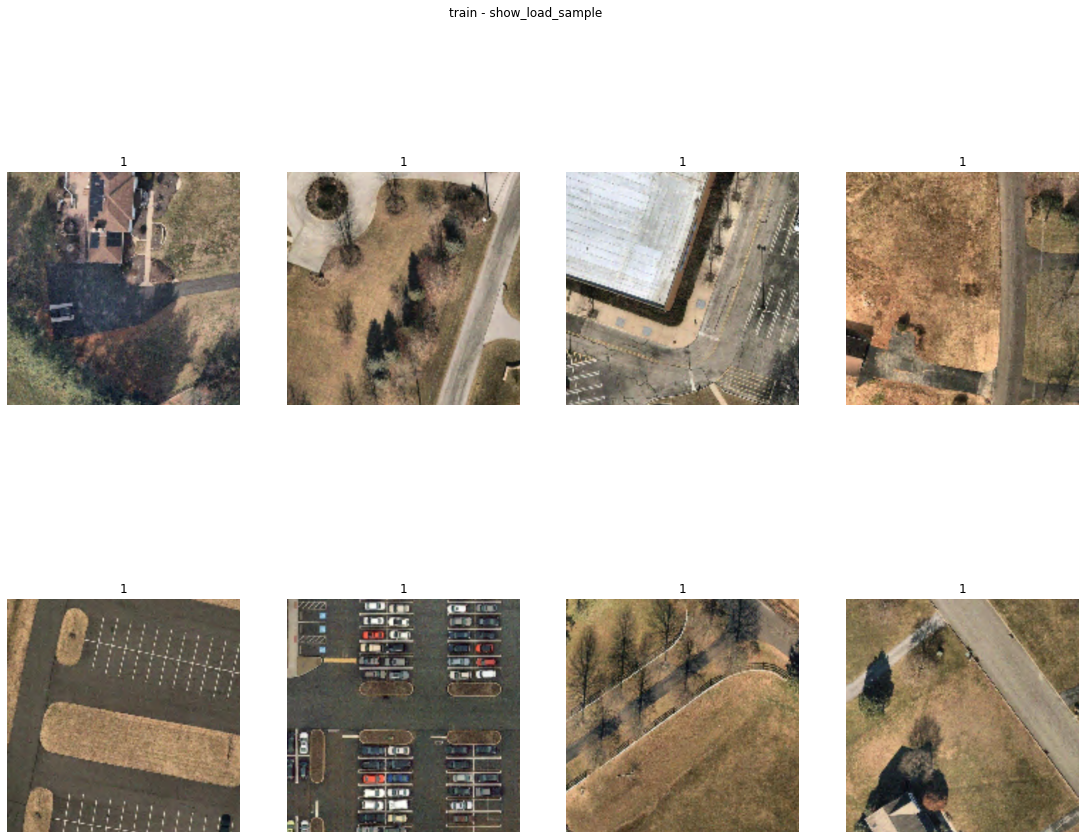

In [20]:
diff_dm.show_train_batch(figsize=(19.2, 14.4))

## Creating the new train & test csv's

In [28]:
diff_pd = pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_drive_service_diff.csv")
df = pd.DataFrame({"image": diff_pd.image.values, "has_road": diff_pd.has_road_x.values})

In [29]:
df

,image,has_road
0,/deep/group/aicc-bootcamp/transportation/data/...,yes
1,/deep/group/aicc-bootcamp/transportation/data/...,yes
2,/deep/group/aicc-bootcamp/transportation/data/...,yes
3,/deep/group/aicc-bootcamp/transportation/data/...,yes
4,/deep/group/aicc-bootcamp/transportation/data/...,no
...,...,...
373,/deep/group/aicc-bootcamp/transportation/data/...,yes
374,/deep/group/aicc-bootcamp/transportation/data/...,yes
375,/deep/group/aicc-bootcamp/transportation/data/...,no
376,/deep/group/aicc-bootcamp/transportation/data/...,yes


In [30]:
df.to_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/hand_labeled_diff.csv")

In [31]:
diff_df = df

In [36]:
all_drive_df = pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_drive_combined.csv")
drive_service_df = pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/drive_service_combined.csv")
df = pd.merge(all_drive_df, drive_service_df, on="image")
df = df.drop(columns=[df.columns[0], df.columns[3]])
df

,image,has_road_x,has_road_y
0,/deep/group/aicc-bootcamp/transportation/data/...,yes,yes
1,/deep/group/aicc-bootcamp/transportation/data/...,yes,yes
2,/deep/group/aicc-bootcamp/transportation/data/...,yes,yes
3,/deep/group/aicc-bootcamp/transportation/data/...,yes,yes
4,/deep/group/aicc-bootcamp/transportation/data/...,yes,yes
...,...,...,...
1500,/deep/group/aicc-bootcamp/transportation/data/...,yes,yes
1501,/deep/group/aicc-bootcamp/transportation/data/...,yes,no
1502,/deep/group/aicc-bootcamp/transportation/data/...,yes,no
1503,/deep/group/aicc-bootcamp/transportation/data/...,yes,yes


In [47]:
common_df = pd.DataFrame({"image": df[df["has_road_x"] == df["has_road_y"]].image.values, "has_road": df[df["has_road_x"] == df["has_road_y"]].has_road_x.values})

In [48]:
common_df

,image,has_road
0,/deep/group/aicc-bootcamp/transportation/data/...,yes
1,/deep/group/aicc-bootcamp/transportation/data/...,yes
2,/deep/group/aicc-bootcamp/transportation/data/...,yes
3,/deep/group/aicc-bootcamp/transportation/data/...,yes
4,/deep/group/aicc-bootcamp/transportation/data/...,yes
...,...,...
1122,/deep/group/aicc-bootcamp/transportation/data/...,yes
1123,/deep/group/aicc-bootcamp/transportation/data/...,yes
1124,/deep/group/aicc-bootcamp/transportation/data/...,yes
1125,/deep/group/aicc-bootcamp/transportation/data/...,yes


In [51]:
new_df = pd.concat([common_df, diff_df])

In [53]:
new_df.has_road.value_counts()

yes    1363
no      142
Name: has_road, dtype: int64

In [58]:
new_df

,image,has_road
0,/deep/group/aicc-bootcamp/transportation/data/...,yes
1,/deep/group/aicc-bootcamp/transportation/data/...,yes
2,/deep/group/aicc-bootcamp/transportation/data/...,yes
3,/deep/group/aicc-bootcamp/transportation/data/...,yes
4,/deep/group/aicc-bootcamp/transportation/data/...,yes
...,...,...
373,/deep/group/aicc-bootcamp/transportation/data/...,yes
374,/deep/group/aicc-bootcamp/transportation/data/...,yes
375,/deep/group/aicc-bootcamp/transportation/data/...,no
376,/deep/group/aicc-bootcamp/transportation/data/...,yes


In [55]:
train_df = pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/train_cleaned.csv")
val_df = pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/val_cleaned.csv")

In [56]:
all_df = pd.concat([train_df, val_df])

In [62]:
all_df = all_df.drop(columns=all_df.columns[0]).reset_index(drop=True)

In [67]:
all_df.has_road.value_counts()

no     10499
yes     1505
Name: has_road, dtype: int64

In [69]:
new_all_df = pd.concat([all_df[all_df["has_road"] == "no"], new_df]).reset_index(drop=True)

In [71]:
new_all_df

,image,has_road
0,/deep/group/aicc-bootcamp/transportation/data/...,no
1,/deep/group/aicc-bootcamp/transportation/data/...,no
2,/deep/group/aicc-bootcamp/transportation/data/...,no
3,/deep/group/aicc-bootcamp/transportation/data/...,no
4,/deep/group/aicc-bootcamp/transportation/data/...,no
...,...,...
11999,/deep/group/aicc-bootcamp/transportation/data/...,yes
12000,/deep/group/aicc-bootcamp/transportation/data/...,yes
12001,/deep/group/aicc-bootcamp/transportation/data/...,no
12002,/deep/group/aicc-bootcamp/transportation/data/...,yes


In [70]:
new_all_df.has_road.value_counts()

no     10641
yes     1363
Name: has_road, dtype: int64

diff is 142, which is the number of yes labels we switched to no!

In [78]:
new_train_df = new_all_df.sample(frac=0.9,random_state=42).reset_index(drop=True)
new_val_df   = new_all_df.drop(new_train_df.index).sample(frac=1.0, random_state=42).reset_index(drop=True)

In [79]:
new_train_df

,image,has_road
0,/deep/group/aicc-bootcamp/transportation/data/...,no
1,/deep/group/aicc-bootcamp/transportation/data/...,no
2,/deep/group/aicc-bootcamp/transportation/data/...,no
3,/deep/group/aicc-bootcamp/transportation/data/...,no
4,/deep/group/aicc-bootcamp/transportation/data/...,no
...,...,...
10799,/deep/group/aicc-bootcamp/transportation/data/...,no
10800,/deep/group/aicc-bootcamp/transportation/data/...,yes
10801,/deep/group/aicc-bootcamp/transportation/data/...,no
10802,/deep/group/aicc-bootcamp/transportation/data/...,no


In [81]:
new_train_df.has_road.value_counts()

no     9594
yes    1210
Name: has_road, dtype: int64

In [80]:
new_val_df

,image,has_road
0,/deep/group/aicc-bootcamp/transportation/data/...,yes
1,/deep/group/aicc-bootcamp/transportation/data/...,yes
2,/deep/group/aicc-bootcamp/transportation/data/...,yes
3,/deep/group/aicc-bootcamp/transportation/data/...,yes
4,/deep/group/aicc-bootcamp/transportation/data/...,yes
...,...,...
1195,/deep/group/aicc-bootcamp/transportation/data/...,yes
1196,/deep/group/aicc-bootcamp/transportation/data/...,yes
1197,/deep/group/aicc-bootcamp/transportation/data/...,yes
1198,/deep/group/aicc-bootcamp/transportation/data/...,yes


In [82]:
new_val_df.has_road.value_counts()

yes    1085
no      115
Name: has_road, dtype: int64

In [83]:
new_train_df.to_csv('/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/train.csv')
new_val_df.to_csv('/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/val.csv')

## Visualize new train and val df's

In [84]:
train_path = "/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/train.csv"

In [86]:
print(pd.read_csv(train_path).has_road.value_counts())
weights, weight_per_class = pd_make_weights_for_balanced_classes(train_path)
weights = torch.DoubleTensor(weights)
print(weights[:8])
print(weight_per_class)

no     9594
yes    1210
Name: has_road, dtype: int64
tensor([1.1261, 1.1261, 1.1261, 1.1261, 1.1261, 1.1261, 1.1261, 1.1261],
       dtype=torch.float64)
no     1.126120
yes    8.928926
Name: has_road, dtype: float64


In [150]:
@dataclass
class ImageClassificationInputTransform(InputTransform):
    image_size: Tuple[int, int] = (500, 500)
    mean: Union[float, Tuple[float, float, float]] = (0.4300, 0.3860, 0.3388)
    std:  Union[float, Tuple[float, float, float]] = (0.1870, 0.1533, 0.1267)

    def per_sample_transform(self):
        return T.Compose(
            [
                ApplyToKeys(
                    "input",
                    T.Compose([T.ToTensor(), T.Resize(self.image_size), T.Normalize(self.mean, self.std)]),
                ),
                ApplyToKeys("target", torch.as_tensor),
            ]
        )

In [146]:
from flash.image.classification.data import MatplotlibVisualization
from flash.core.utilities.imports import requires
from flash.core.data.callback import BaseDataFetcher
from typing import Any, Callable, Collection, Dict, List, Optional, Sequence, Tuple, Type, Union

class CustomVisualization(MatplotlibVisualization):
    @requires("matplotlib")
    def _show_images_and_labels(
        self,
        data: List[Any],
        num_samples: int,
        title: str,
        limit_nb_samples: int = None,
        figsize: Tuple[int, int] = (6.4, 4.8),
    ):
        num_samples = max(1, min(num_samples, limit_nb_samples))

        # define the image grid
        cols: int = min(num_samples, self.max_cols)
        rows: int = num_samples // cols

        # create figure and set title
        fig, axs = plt.subplots(rows, cols, figsize=figsize)
        fig.suptitle(title)

        if not isinstance(axs, np.ndarray):
            axs = np.array(axs)
        axs = axs.flatten()

        for i, ax in enumerate(axs):
            # unpack images and labels
            if isinstance(data, list):
                _img, _label = data[i][DataKeys.INPUT], data[i].get(DataKeys.TARGET, "")
                _path = data[i][DataKeys.METADATA]['filepath']
            elif isinstance(data, dict):
                _img, _label = data[DataKeys.INPUT][i], data.get(DataKeys.TARGET, [""] * (i + 1))[i]
                _path = data[DataKeys.METADATA][i]['filepath']
            else:
                raise TypeError(f"Unknown data type. Got: {type(data)}.")
            # convert images to numpy
            _img: np.ndarray = self._to_numpy(_img)
            if isinstance(_label, Tensor):
                _label = _label.squeeze().tolist()
            # show image and set label as subplot title
            ax.imshow(_img)
            ax.set_title(str(_label) + " | " + Path(_path).stem)
            ax.axis("off")
        plt.show(block=self.block_viz_window)

class CustomImageClassificationData(ImageClassificationData):
    @staticmethod
    def configure_data_fetcher(*args, **kwargs) -> BaseDataFetcher:
        return CustomVisualization(*args, **kwargs)


In [ ]:
train_dm = CustomImageClassificationData.from_csv(
    "image",
    "has_road",
    train_file=train_path,
    target_formatter=flash.core.data.utilities.classification.SingleLabelTargetFormatter(labels=["no", "yes"]),
    transform=ImageClassificationInputTransform(),
    sampler=torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True),
    batch_size=8,
    num_workers=4
)

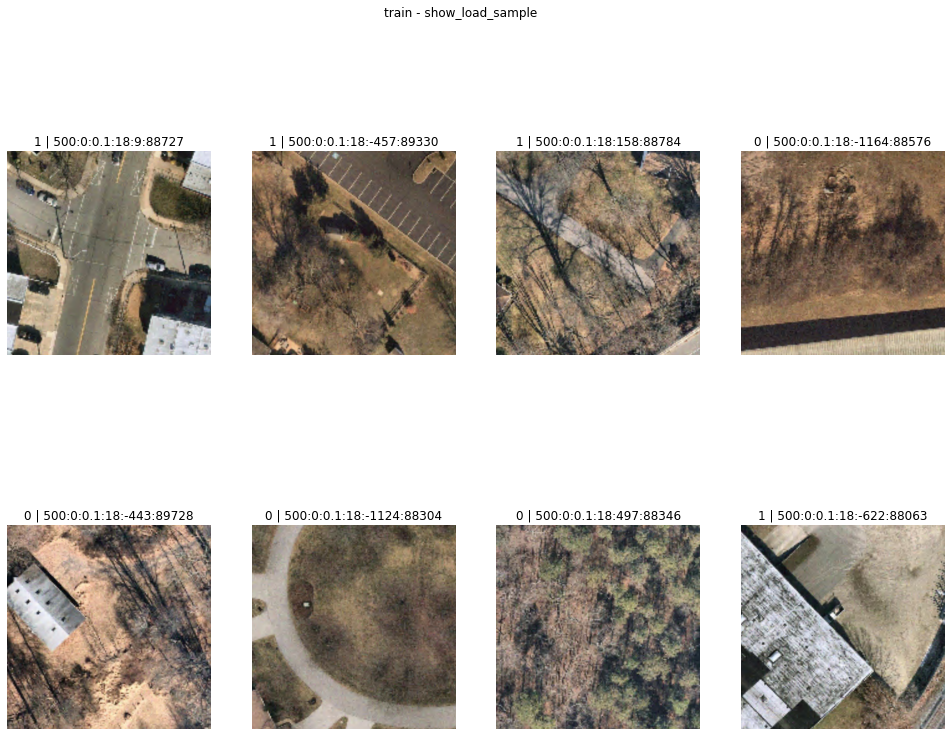

In [152]:
train_dm.show_train_batch(figsize=(16.8, 12.6))

## Make a new all negatives CSV

In [156]:
new_all_df[new_all_df.has_road=="no"].reset_index(drop=True).to_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_negatives_combined.csv")

In [ ]:
new_all_df[new_all_df.has_road=="yes"].reset_index(drop=True).to_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_positives_combined.csv")

In [162]:
new_all_df.to_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_examples_combined.csv")